# TABLA 3 de ZOTENKO

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pylab as plt
%matplotlib inline
import os
from random import shuffle
import math
import pandas as pd
from scipy import optimize

In [2]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data

def grafo(datosRed):
    G = nx.Graph()
    for i in range(np.shape(datosRed)[0]):
        G.add_edges_from([(datosRed[i][0],datosRed[i][1])])
    return G 

APMS = ldata('yeast_AP-MS.txt')
GAPMS = grafo(APMS)

Y2H=ldata('yeast_Y2H.txt')
GY2H=grafo(Y2H)

LIT=ldata('yeast_LIT.txt')
GLIT=grafo(LIT)

LIT_R=ldata('yeast_LIT_Reguly.txt')
GLIT_R=grafo(LIT_R)

In [3]:
essentiality=ldata('Essential.txt')

ess=[]
for i in range(len(essentiality)):
    ess.append(essentiality[i][1])
    
def essentiality(nodo): 
    if len({nodo}.intersection(set(ess)))==0:
        e=0
    else:
        e=1
    return e   

def AssignEssentiality(G,dict_ess):
    for n in G.nodes:
        G.nodes[n]["essentiality"] = dict_ess[n]
    return

def NodosEsenciales(G):
    dict_ess = { nodo: essentiality(nodo) for nodo  in G.nodes() }
    AssignEssentiality(G,dict_ess)
    nodosesenciales=[]
    nodosnoesenciales=[]
    for nodo in list(set(G.nodes())):
        if G.nodes.data("essentiality")[nodo]==1:
            nodosesenciales.append(nodo)
        if G.nodes.data("essentiality")[nodo]==0:
            nodosnoesenciales.append(nodo)
    return(nodosesenciales,nodosnoesenciales)

Quiero funcion que saque todos los nodos esenciales de mi componente gigante y de como resultado TamañoCG_final/TamañoCG_original

Importo datos del item anterior

In [5]:
EfectoEsencial=np.loadtxt('EfectoEsencial.txt',delimiter=',')

# Voy a mirar las distribuciones de grado de esenciales y no esenciales para poder elegir un criterio...

In [14]:
def DistribucionGradoEssVsNoEss(G):
    Gc=max(nx.connected_component_subgraphs(G), key=len)
    Esenciales,NoEsenciales=NodosEsenciales(Gc)
    #NoEsenciales=[]
    #for node in list(Gc.nodes()):
    #    if len({node}.intersection(set(Esenciales)))==0:
    #        NoEsenciales.append(node)
            
    GradoEsenciales = list(dict(Gc.degree(Esenciales)).values())
    GradoNoEsenciales = list(dict(Gc.degree(NoEsenciales)).values())
    plt.hist(GradoEsenciales,bins=range(min(GradoEsenciales), max(GradoEsenciales) + 1, 1),histtype='step',label='esenciales')
    plt.hist(GradoNoEsenciales,bins=range(min(GradoNoEsenciales), max(GradoNoEsenciales) + 1, 1),histtype='step',label='no esenciales')
    plt.xlabel('Grado')
    plt.ylabel('Cantidad de nodos en CG')
    plt.legend()

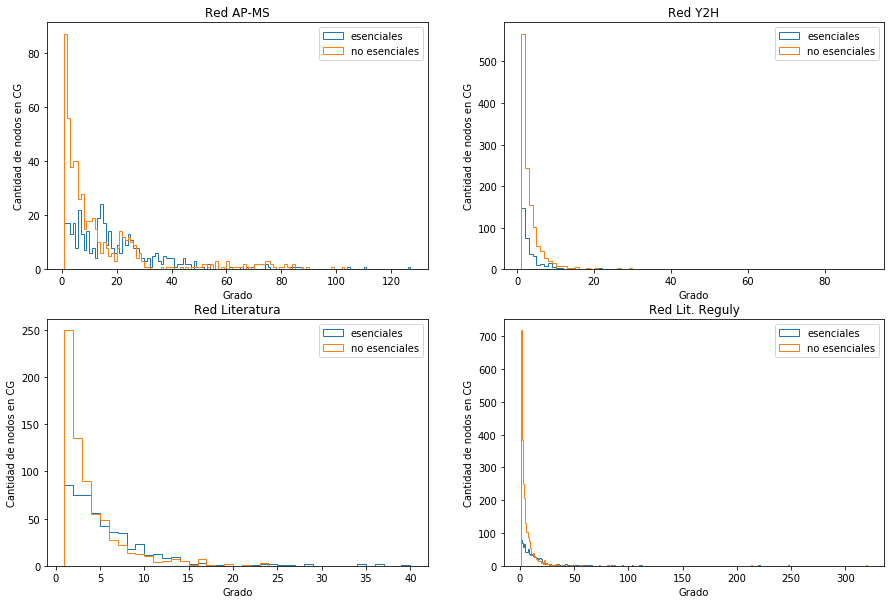

In [20]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1) 
plt.title('Red AP-MS')
DistribucionGradoEssVsNoEss(GAPMS)

plt.subplot(2, 2, 2) 
plt.title('Red Y2H')
DistribucionGradoEssVsNoEss(GY2H)

plt.subplot(2, 2, 3) 
plt.title('Red Literatura')
DistribucionGradoEssVsNoEss(GLIT)

plt.subplot(2, 2, 4) 
plt.title('Red Lit. Reguly')
DistribucionGradoEssVsNoEss(GLIT_R)

plt.savefig('distribucion.png')

In [9]:
def EsencialesYNoEsenciales(G):
    Gc=max(nx.connected_component_subgraphs(G), key=len)
    Esenciales,NoEsenciales=NodosEsenciales(Gc)
    GradoEsenciales = Gc.degree(Esenciales)
    GradoNoEsenciales = Gc.degree(NoEsenciales)
    return(GradoEsenciales,GradoNoEsenciales)

In [10]:
GradoEsencialesAPMS,GradoNoEsencialesAPMS=EsencialesYNoEsenciales(GAPMS)
GradoEsencialesY2H,GradoNoEsencialesY2H=EsencialesYNoEsenciales(GY2H)
GradoEsencialesLIT,GradoNoEsencialesLIT=EsencialesYNoEsenciales(GLIT)
GradoEsencialesLIT_R,GradoNoEsencialesLIT_R=EsencialesYNoEsenciales(GLIT_R)


In [12]:
max(dict(GradoEsencialesY2H).values())

91

# BINEO LOGARITMICO

In [66]:
#SERIE DE BINEO
serie = []
serie.append(1)
imax=9
for k in range(imax):
    serie.append(int(serie[k]+2**k))
    
serie


[1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

In [481]:
def NodosPorBin(G,serie):
    GradoEsenciales,GradoNoEsenciales=EsencialesYNoEsenciales(G)
    GradosE=list(dict(GradoEsenciales).values())
    GradosNoE=list(dict(GradoNoEsenciales).values())
    CantidadE = []
    NodosE=[]
    CantidadNoE=[]
    NodosNoE=[]
    for i in range(len(serie)):
        cantE = [d for d in GradosE if serie[i] <= d and d< serie[i+1]-0.1] 
        nodosE=[n for n,d in GradoEsenciales if serie[i] <= d and d< serie[i+1]-0.1]
        cantNoE = [d for d in GradosNoE if serie[i] <= d and d< serie[i+1]-0.1] 
        nodosNoE = [n for n,d in GradoNoEsenciales if serie[i] <= d and d< serie[i+1]-0.1] 
        
        CantidadE.append(len(cantE)) 
        NodosE.append(nodosE)
        CantidadNoE.append(len(cantNoE))
        NodosNoE.append(nodosNoE)
    a=0
    for l in range(len(CantidadE)):
        if CantidadE[l]<=CantidadNoE[l]:
            a=a+1
    if a==len(CantidadE):
        print('ESTA SERIE SIRVE')
    else:
        print('DEMASIADOS ESENCIALES')
    return(CantidadE,NodosE,CantidadNoE,NodosNoE)

In [420]:
def AgarraNoEsenciales(CantidadE,NodosNoE,m):
    CombinacionesNoEsenciales=[]
    for j in range(m):
        NodosElegidos=[]
        for i in range(len(CantidadE)):
            n=CantidadE[i]
            no_esenciales=np.random.permutation(NodosNoE[i])[:n-1]
            NodosElegidos.extend(no_esenciales) #concateno los elegidos
        CombinacionesNoEsenciales.append(NodosElegidos)
    return(CombinacionesNoEsenciales)

In [435]:
def SinNoEsenciales(G,CombinacionesNoEsenciales):
    GcNoEsencial = max(nx.connected_component_subgraphs(G), key=len) #Me creo una copia de la componente Gigante Original.
    LengthOriginalGc=len(GcNoEsencial)
    LGC=[]
    for i in range(len(CombinacionesNoEsenciales)):
        GDesarmable=max(nx.connected_component_subgraphs(G.copy()), key=len)
        for nodo in CombinacionesNoEsenciales[i]:
            GDesarmable.remove_node(nodo)
        LGC.append(float(len(max(nx.connected_component_subgraphs(GDesarmable), key=len)))/LengthOriginalGc)
    LGC_mean=np.mean(LGC)
    LGC_std=np.std(LGC)
    return LGC_mean,LGC_std

In [467]:
serieY2H=[1, 2, 3,4, 5,6,7,8,9, 10,11,12,13,14,16,20,28,40,50, 129]
serieLIT=[1, 2,50]
serieAPMS=[1, 2, 3, 4, 6, 35, 82, 128]
serieLIT_R=[1, 2, 3, 4, 5,6,7, 8,128, 350]

In [524]:
CantidadE_LIT,NodosE_LIT,CantidadNoE_LIT,NodosNoE_LIT=NodosPorBin(GLIT,serieLIT)
CombinacionesNoEsenciales_LIT=AgarraNoEsenciales(CantidadE_LIT,NodosNoE_LIT,5000)
LGC_mean_LIT,LGC_std_LIT=SinNoEsenciales(GLIT,CombinacionesNoEsenciales_LIT)
LGC_mean_LIT,LGC_std_LIT


ESTA SERIE SIRVE


(0.42276389117889523, 0.005843255231996505)

In [521]:
CantidadE_Y2H,NodosE_Y2H,CantidadNoE_Y2H,NodosNoE_Y2H=NodosPorBin(GY2H,serieY2H)
CombinacionesNoEsenciales_Y2H=AgarraNoEsenciales(CantidadE_Y2H,NodosNoE_Y2H,1000)
LGC_mean_Y2H,LGC_std_Y2H=SinNoEsenciales(GY2H,CombinacionesNoEsenciales_Y2H)
LGC_mean_Y2H,LGC_std_Y2H

ESTA SERIE SIRVE


(0.6869708561020036, 0.010240843276752551)

In [522]:
CantidadE_APMS,NodosE_APMS,CantidadNoE_APMS,NodosNoE_APMS=NodosPorBin(GAPMS,serieAPMS)
CombinacionesNoEsenciales_APMS=AgarraNoEsenciales(CantidadE_APMS,NodosNoE_APMS,1000)
LGC_mean_APMS,LGC_std_APMS=SinNoEsenciales(GAPMS,CombinacionesNoEsenciales_APMS)
LGC_mean_APMS,LGC_std_APMS

ESTA SERIE SIRVE


(0.38907370517928286, 0.01939376541607375)

In [523]:
CantidadE_LIT_R,NodosE_LIT_R,CantidadNoE_LIT_R,NodosNoE_LIT_R=NodosPorBin(GLIT_R,serieLIT_R)
CombinacionesNoEsenciales_LIT_R=AgarraNoEsenciales(CantidadE_LIT_R,NodosNoE_LIT_R,1000)
LGC_mean_LIT_R,LGC_std_LIT_R=SinNoEsenciales(GLIT_R,CombinacionesNoEsenciales_LIT_R)
LGC_mean_LIT_R,LGC_std_LIT_R

ESTA SERIE SIRVE


(0.5639441687344913, 0.020601002069286983)